In [152]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from cobra.io import read_sbml_model


model = read_sbml_model("../model/Rpom_05.xml")

https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http

In [154]:
# Load all reaction and protein data from both databases
import pickle

# Proteins
with open("../model_building/biocyc_update_pipeline/data/raw_protein_data__RUEGERIA_POMEROYI_DSS3.pkl", "rb") as f:
    proteins1 = pickle.load(f)
with open("../model_building/biocyc_update_pipeline/data/raw_protein_data__GCF_000011965.pkl", "rb") as f:
    proteins2 = pickle.load(f)
proteins1 = {protein["@frameid"]: protein for protein in proteins1}
proteins2 = {protein["@frameid"]: protein for protein in proteins2}

# Reactions
with open("../model_building/biocyc_update_pipeline/data/raw_reaction_data__RUEGERIA_POMEROYI_DSS3.pkl", "rb") as f:
    reactions1 = pickle.load(f)
with open("../model_building/biocyc_update_pipeline/data/raw_reaction_data__GCF_000011965.pkl", "rb") as f:
    reactions2 = pickle.load(f)

In [155]:
from model_building.biocyc_update_pipeline.transform.build_templates import get_gene_reaction_rule

gprs1 = pd.DataFrame(
    [
        {"ID": rxndata["@frameid"], "GPR": get_gene_reaction_rule(rxndata, proteins1)}
        for rxndata in reactions1
    ]
)

gprs2 = pd.DataFrame(
    [
        {"ID": rxndata["@frameid"], "GPR": get_gene_reaction_rule(rxndata, proteins2)}
        for rxndata in reactions2
    ]
)

In [208]:
def get_ec(rxn_data):
    temp = rxn_data.get("ec-number", {})
    if isinstance(temp, str):
        return temp
    elif isinstance(temp, list):
        return ", ".join([elem if isinstance(elem, str) else elem.get("#text", "") for elem in temp])
    elif isinstance(temp, dict):
        return temp.get("#text", "")
    else:
        raise ValueError("Invalid type")

ec_db1 = pd.DataFrame([{"ID": rxn["@frameid"],
               "EC DB1": get_ec(rxn)}
              for rxn in reactions1])

ec_db2 = pd.DataFrame([{"ID": rxn["@frameid"],
               "EC DB2": get_ec(rxn)}
              for rxn in reactions2])

In [156]:
# Filter to reactions that are
# 1) in the model, and
# 2) with no genes in either DB.

all_gprs = gprs1.merge(gprs2, left_on="ID", right_on="ID", suffixes=[" db1", " db2"], how="outer")
gprs_in_model = all_gprs[[rxnid in model.reactions for rxnid in all_gprs["ID"]]]

gap_filled_in_model = gprs_in_model[[
    (pd.isna(gpr1) or gpr1 == "()") and (pd.isna(gpr2) or gpr2 == "()")
    for _, (_, gpr1, gpr2) in gprs_in_model.iterrows()
]]

(array([ 13.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 313.]),
 array([0.        , 0.02885046, 0.05770092, 0.08655138, 0.11540185,
        0.14425231, 0.17310277, 0.20195323, 0.23080369, 0.25965415,
        0.28850462, 0.31735508, 0.34620554, 0.375056  , 0.40390646,
        0.43275692, 0.46160738, 0.49045785, 0.51930831, 0.54815877,
        0.57700923]),
 <BarContainer object of 20 artists>)

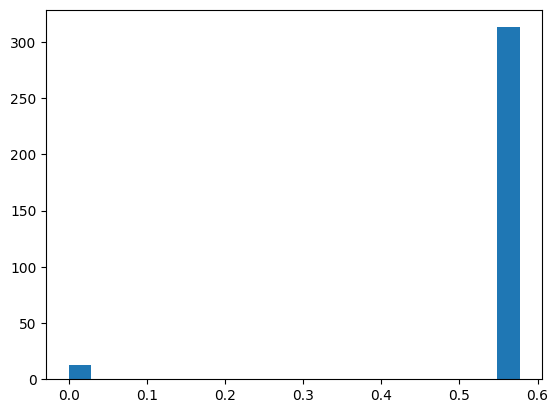

In [157]:
# Rank by growth impact of deletion on glucose growth
with model:
    model.reactions.get_by_id("EX_glc").bounds = (-5.44, 0)

    baseline_mu = model.optimize()

    growth_rates = {}
    for rxn in gap_filled_in_model["ID"]:
        with model:
            model.reactions.get_by_id(rxn).bounds = (0.,0.)
            growth_rates[rxn] = model.optimize().objective_value


fig, ax = plt.subplots()
ax.hist(growth_rates.values(), bins=20)

In [211]:
result = gap_filled_in_model.copy()

# Links to biocyc
result = result.merge(pd.DataFrame([
    {"ID": rxnid,
     "Link DB1": f"https://biocyc.org/reaction?orgid=RUEGERIA_POMEROYI_DSS3&id={rxnid}",
     "Link DB2" : f"https://biocyc.org/reaction?orgid=GCF_000011965&id={rxnid}"}
    for rxnid in result["ID"]]),
    left_on="ID", right_on="ID")

# EC numbers
result = result.merge(ec_db1, on="ID").merge(ec_db2, on="ID")

# Model data
result = result.merge(pd.DataFrame([{"ID" : rxn, "mu" : mu} for rxn, mu in growth_rates.items()]),
             left_on="ID", right_on="ID")
result["Flux"] = [baseline_mu[rxn] for rxn in result["ID"]]
result["Abs Flux"] = result["Flux"].abs()
result["Fold-Change"] = result["mu"] / baseline_mu.objective_value
result.sort_values("Abs Flux", ascending=False).sort_values("Fold-Change")


result

,ID,GPR db1,GPR db2,Link DB1,Link DB2,EC DB1,EC DB2,mu,Flux,Abs Flux,Fold-Change
0,RXN-11741,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,,,0.577009,0.000000,0.000000,1.0
1,RXN-7800,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,,,0.577009,0.000000,0.000000,1.0
2,RXN-11667,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,EC-4.2.1.150,EC-4.2.1.150,0.577009,0.000000,0.000000,1.0
3,PPPGPPHYDRO-RXN,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,EC-3.6.1.40,EC-3.6.1.40,0.577009,0.000000,0.000000,1.0
4,RXN-16112,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,EC-1.1.1.330,EC-1.1.1.330,0.577009,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
119,PSEUDOURIDINE-KINASE-RXN,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,EC-2.7.1.83,EC-2.7.1.83,0.577009,0.000000,0.000000,1.0
120,RXN-17900,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,,,0.577009,0.045424,0.045424,1.0
121,RXN-4821,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,EC-3.5.99,EC-3.5.99,0.577009,0.000000,0.000000,1.0
122,RXN-8899,(),(),https://biocyc.org/reaction?orgid=RUEGERIA_POM...,https://biocyc.org/reaction?orgid=GCF_00001196...,,,0.577009,0.000000,0.000000,1.0


In [216]:
model.reactions.get_by_id("FHLMULTI-RXN")

Reaction identifier,FHLMULTI-RXN
Name,FHLMULTI-RXN
Memory address,0x7c8616898a40
Stoichiometry,FORMATE[c] + PROTON[c] --> CARBON-DIOXIDE[c] + HYDROGEN-MOLECULE[c] formate + H+ --> CO2 + H2
GPR,
Lower bound,0.0
Upper bound,1000.0


In [174]:
result.sort_values("Abs Flux", ascending=False).sort_values("Fold-Change").to_clipboard(index=False)

In [212]:
result.sort_values("Abs Flux", ascending=False).sort_values("Fold-Change")[["EC DB1", "EC DB2"]].to_clipboard(index=False)